### Neighborhood Reconstruction Methods (chapter 3 of book)

#### Encoder-Decoder

- The goal is to learn (graph) node embeddings, which encode the nodes as low-dimensional vectors, capturing the nodes graph position and their neighborhood structure.
- Nodes are projected into a latent/hidden space, where geometric relationships between the embeddings correspond to the relationships in the original graph.
- Node embedding can be approached with the _encoding-decoding_ framework.
- This is an example of "graph representation learning": the act of learning a representation of the graph.
- Two operations in this learning process are the _encoder_ (mapping nodes to vectors), and the _decoder_, which reconstruct information about the original nodes based on the vector embeddings (this is vague, but will be made precise).
- Example of shallow embedding as encoder: $ENC: V \to \mathbb{R}^d$. Notation: $ENC(v) = z_v$. 
    - The encoder is a lookup function: $ENC(v) = Z[v]$, where $Z \in \mathbb{R}^{|V|\times d}$, a matrix with all the embeddings as rows, and $Z[v]$ denoting the row corresponding to $v \in V$.
    - More general encoders use information about the graph, beyond the node id, for example node features or local graph structure.
- The decoder aims to recover graph information based on the embeddings.
- Example: pairwise decoder: $DEC: \mathbb{R}^d \times \mathbb{R}^d \to \mathbb{R}$, aiming to recover the similarity between nodes based on the corresponding embeddings.
- Optimize (learn) ENC, DEC so that: $$ DEC(ENC(u), ENC(v)) = DEC(z_u, z_v) \approx S(u,v)$$ where $S(u,v)$ is a similarity defined on pairs of graph nodes.
- Some examples of Similarities:
    - $S(u,v) = A(u,v)$, where $A$ is the adjacency matrix.
    - $S(u,v) = \frac{|N(u)\cap N(v)|}{|N(u)\cup N(v)|}$.
    - $S(u,v) = \sum_{w in N(u)\cap N(v)} \frac{1}{d_w}$.


#### Optimizing an Encoder-Decoder Model

- To train $DEC$ and $ENC$ to obtain $DEC(ENC(u), ENC(v)) = DEC(z_u, z_v) \approx S(u,v)$, we do loss minimization. 
- Minimize $$\mathscr{L} = \sum_{(u,v) \in D} l(DEC(z_u, z_v), S(u,v))$$ over the training nodes $D$.
- What determines an approach is the choice of: (1) loss $l$, (2) graph similarity, (3) decoder $DEC$.
- For example:
    - Any of the 3 similarities above.
    - Decoder: $DEC(z_u, z_v) = z_u^Tz_v$.
    - Loss: $l(DEC(z_u, z_v), S(u,v)) = ||DEC(z_u, z_v) - S(u,v)||_2^2$. 



#### Little experiement
- Create a graph, visualize it, put color intensity according to the centrality (compute centrality).
- Create embeddings to the plane. Learn the embeddings (encoder & decoder).
- Check that the learned models have the desired property.
- Do this for the 3 kinds of similarities above.
- Visualize the embeddings as well.
- Have a way to create graphs manually, with a UI in the notebook, and get the embeddings generated.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from scipy.sparse import csr_matrix
import torch

In [9]:
def generate_random_graph(N, p, seed=None):
    """
    Generate an Erdős-Rényi random graph.
    
    Parameters:
    - N: number of nodes
    - p: probability of edge creation between any two nodes
    - seed: random seed for reproducibility
    
    Returns:
    - G: NetworkX graph object
    - adj_matrix: adjacency matrix as numpy array
    - edge_index: edge indices in PyTorch geometric format (2 x num_edges)
    """
    if seed is not None:
        np.random.seed(seed)
    
    # Create adjacency matrix
    adj_matrix = np.zeros((N, N))
    
    # For each pair of nodes, create edge with probability p
    for i in range(N):
        for j in range(i+1, N):  # Only upper triangle to avoid duplicates
            if np.random.random() < p:
                adj_matrix[i, j] = 1
                adj_matrix[j, i] = 1  # Make symmetric for undirected graph
    
    # Create NetworkX graph
    G = nx.from_numpy_array(adj_matrix)
    
    # Create edge_index for PyTorch Geometric format
    edges = np.nonzero(adj_matrix)
    edge_index = torch.tensor(np.vstack(edges), dtype=torch.long)
    
    return G, adj_matrix, edge_index

def visualize_graph(G, N, p, figsize=(10, 8)):
    """
    Visualize the graph with nice layout and statistics.
    Attempts planar layout if the graph is planar.
    """
    plt.figure(figsize=figsize)
    
    # Check if graph is planar
    is_planar, planar_embedding = nx.check_planarity(G)
    
    # Choose layout based on planarity and graph size
    if is_planar and N <= 100:  # Use planar layout for smaller planar graphs
        try:
            pos = nx.planar_layout(G)
            layout_name = "Planar"
        except:
            # Fallback to spring layout if planar layout fails
            pos = nx.spring_layout(G, k=1, iterations=50)
            layout_name = "Spring (planar layout failed)"
    else:
        # Use spring layout for non-planar or large graphs
        if N <= 50:
            pos = nx.spring_layout(G, k=1, iterations=50)
        else:
            pos = nx.spring_layout(G, k=0.5, iterations=30)
        layout_name = "Spring"
    
    # Draw the graph
    node_color = 'lightgreen' if is_planar else 'lightblue'
    nx.draw(G, pos, 
            node_color=node_color, 
            node_size=300 if N <= 50 else 100,
            edge_color='gray', 
            width=1,
            with_labels=True if N <= 20 else False,
            font_size=8)
    
    # Add statistics
    num_edges = G.number_of_edges()
    max_possible_edges = N * (N - 1) // 2
    actual_density = num_edges / max_possible_edges if max_possible_edges > 0 else 0
    
    planarity_text = "PLANAR" if is_planar else "NON-PLANAR"
    plt.title(f'Random Graph ({planarity_text}) - {layout_name} Layout\n'
              f'N={N}, p={p}, Edges: {num_edges}/{max_possible_edges} '
              f'(density: {actual_density:.3f})')
    
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    
    # Print additional statistics
    print(f"Graph Statistics:")
    print(f"  Nodes: {N}")
    print(f"  Edges: {num_edges}")
    print(f"  Expected edges: {p * max_possible_edges:.1f}")
    print(f"  Density: {actual_density:.3f}")
    print(f"  Is connected: {nx.is_connected(G)}")
    print(f"  Is planar: {is_planar}")
    if is_planar:
        print(f"  ✓ Graph can be drawn without edge crossings!")
    else:
        print(f"  ✗ Graph requires edge crossings (non-planar)")
    if nx.is_connected(G):
        print(f"  Average shortest path: {nx.average_shortest_path_length(G):.2f}")
    print(f"  Average clustering coefficient: {nx.average_clustering(G):.3f}")
    
    return is_planar



/tmp/ipykernel_93413/785568523.py:85: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


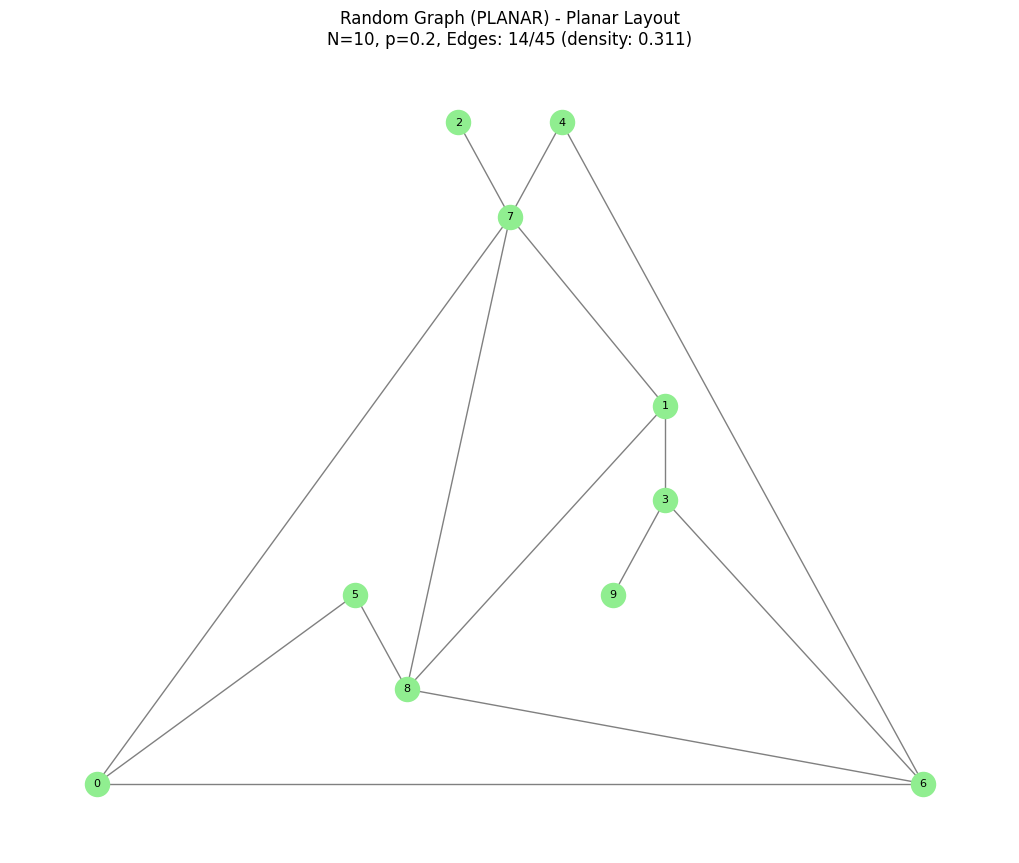

Graph Statistics:
  Nodes: 10
  Edges: 14
  Expected edges: 9.0
  Density: 0.311
  Is connected: True
  Is planar: True
  ✓ Graph can be drawn without edge crossings!
  Average shortest path: 1.98
  Average clustering coefficient: 0.060

PyTorch tensors:
Adjacency matrix shape: (10, 10)
Edge index shape: torch.Size([2, 28])
Edge index (first 10 edges):
tensor([[0, 0, 0, 1, 1, 1, 2, 3, 3, 3],
        [5, 6, 7, 3, 7, 8, 7, 1, 6, 9]])
Adjacency tensor shape: torch.Size([10, 10])

PLANARITY EXPLORATION:
Small sparse graph (N=10, p=0.1): PLANAR
Small medium density (N=10, p=0.3): PLANAR
Medium sparse graph (N=15, p=0.2): PLANAR
Larger sparse graph (N=20, p=0.15): PLANAR
Small dense graph (N=8, p=0.5): NON-PLANAR

Planarity Summary: 4/5 graphs were planar

Note: Larger graphs and higher edge probabilities are less likely to be planar.
Planar graphs have at most 3N-6 edges (for N≥3), so high-density random graphs are rarely planar.


In [ ]:
# Example usage
if __name__ == "__main__":
    # Parameters
    N = 10  # Number of nodes
    p = 0.15  # Edge probability
    
    # Generate graph
    G, adj_matrix, edge_index = generate_random_graph(N, p, seed=42)
    
    # Visualize with planarity check
    is_planar = visualize_graph(G, N, p)
    
    # # Display adjacency matrix
    # plt.figure(figsize=(8, 6))
    # plt.imshow(adj_matrix, cmap='Blues', interpolation='nearest')
    # plt.title(f'Adjacency Matrix (N={N}, p={p})')
    # plt.colorbar()
    # plt.show()
    
    # Print PyTorch tensors for ML use
    print(f"\nPyTorch tensors:")
    print(f"Adjacency matrix shape: {adj_matrix.shape}")
    print(f"Edge index shape: {edge_index.shape}")
    print(f"Edge index (first 10 edges):\n{edge_index[:, :10]}")
    
    # Convert to PyTorch tensors
    adj_tensor = torch.from_numpy(adj_matrix).float()
    print(f"Adjacency tensor shape: {adj_tensor.shape}")
    
    # Test different parameter combinations to explore planarity
    print("\n" + "="*50)
    print("PLANARITY EXPLORATION:")
    print("="*50)
    
    test_params = [
        (10, 0.1, "Small sparse graph"),
        (10, 0.3, "Small medium density"),
        (15, 0.2, "Medium sparse graph"),
        (20, 0.15, "Larger sparse graph"),
        (8, 0.5, "Small dense graph"),
    ]
    
    planar_count = 0
    total_tests = len(test_params)
    
    for n, prob, description in test_params:
        G_test, _, _ = generate_random_graph(n, prob, seed=None)
        is_planar_test, _ = nx.check_planarity(G_test)
        planarity_status = "PLANAR" if is_planar_test else "NON-PLANAR"
        print(f"{description} (N={n}, p={prob}): {planarity_status}")
        if is_planar_test:
            planar_count += 1
    
    print(f"\nPlanarity Summary: {planar_count}/{total_tests} graphs were planar")
    print("\nNote: Larger graphs and higher edge probabilities are less likely to be planar.")
    print("Planar graphs have at most 3N-6 edges (for N≥3), so high-density random graphs are rarely planar.")